# Initialization

In [27]:
import os
from pathlib import Path

import numpy as np
import warnings
warnings.filterwarnings('ignore', message='No contour levels were found')
warnings.filterwarnings('ignore', message='Passing method to Float64Index.get_loc')
warnings.filterwarnings('ignore', message='All-NaN slice encountered')

import tempfile
import shutil

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath

mpl.rcParams['font.size'] = 10
mpl.rcParams['figure.dpi'] = 150
# # mpl.rcParams['pdf.use14corefonts'] = True
# # mpl.rcParams['pdf.fonttype'] = 42
# # mpl.rcParams['font.sans-serif'] = 'DejaVu Sans'
mpl.rcParams['hatch.linewidth'] = 0.5
mpl.rcParams['hatch.color'] = '0.25'

colors = ['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

import cmocean

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import xarray as xr

import ipywidgets as widgets
import xgcm

from numpy import pi as π

import sys
sys.path.append('../../MOM6-examples/tools/analysis')
# m6toolbox is a python package that has a function that helps visualize vertical sections
import m6toolbox

# sys.path.insert(0, '../pittwolfe')
import pittwolfe as pw
from pittwolfe.util import sind, cosd

latFormatter = pw.plt.LatitudeFormatter(direction_labels=False)
lonFormatter = pw.plt.LongitudeFormatter(direction_labels=False)

## Specify the experiment

In [77]:
####
# flat bottom 2-layer base 0.5º experiment
# expdir = '../../flat/base'
# recirc_lon = [0, 8]
# recirc_lat = [32, 39]
# recirc_lon0 = 1.25
# Ah = 1e4

####
# flat bottom 2-layer 0.25º experiment
# expdir = '../../flat/0.25'
# recirc_lon = [0, 8]
# recirc_lat = [32, 39]
# recirc_lon0 = 1.25
# Ah = 900

####
# flat bottom 2-layer 0.5º experiment with GM & K = 500
# expdir = '../../flat/gm_0500'
# recirc_lon = [0, 8]
# recirc_lat = [32, 39]
# recirc_lon0 = 1.25
# Ah = 1e4

####
# flat bottom 3-layer base 0.5º experiment
# expdir = '../../flat/3layer/0.5'
# recirc_lon = [0, 8]
# recirc_lat = [32, 39]
# recirc_lon0 = 1.25
# Ah = 1e4

####
# flat bottom 3-layer 0.25º experiment
# expdir = '../../flat/3layer/0.25'
# recirc_lon = [0, 8]
# recirc_lat = [31, 38]
# Ah = 900

####
# flat bottom 3-layer 0.125º experiment
# expdir = '../../flat/3layer/0.125'
# recirc_lon = [0, 10]
# recirc_lat = [28, 38]
# Ah = 100

####
# flat bottom 3-layer 0.125º experiment without Smagorinski viscosity
# expdir = '../../flat/3layer/0.125/nosmag'
# recirc_lon = [0, 10]
# recirc_lat = [26, 36]
# Ah = 100

####
# sloping sidewalls, 0.5º 
# expdir = '../../slope/base'
# recirc_lon0 = 1.25
# recirc_lon = [0, 8]
# recirc_lat = [32, 39]
# Ah = 1e4

####
# sloping sidewalls, 0.25º 
# expdir = '../../slope/0.25'
# recirc_lon0 = 4.5
# recirc_lon = [0, 10]
# recirc_lat = [31, 38]
# Ah = 900

####
# sloping sidewalls, 3-layer, 0.5º 
# expdir = '../../slope/3layer/0.5'
# recirc_lon0 = 1.25
# recirc_lon = [0, 8]
# recirc_lat = [32, 39]
# Ah = 1e4

####
# sloping sidewalls, 3-layer, 0.125º 
expdir = '../slope/3layer/08/002'
recirc_lon = [2, 12]
recirc_lat = [28, 38]
Ah = 100

####
# sloping sidewalls, 3-layer, 0.125º no smag
# expdir = '../../slope/3layer/0.125/nosmag'
# recirc_lon = [2, 12]
# recirc_lat = [28, 38]
# Ah = 100

snapdir = os.path.join(expdir, 'snapshot/zeta')
Path(snapdir).mkdir(exist_ok=True, parents=True)

def savefig(fig, name, pdf=True, png=True):
    if pdf:
        fig.savefig(os.path.join(expdir, name + '.pdf'), bbox_inches='tight')
    if png:
        fig.savefig(os.path.join(expdir, name + '.png'), bbox_inches='tight', dpi=150)

# Function definitions

<GeoAxes: >

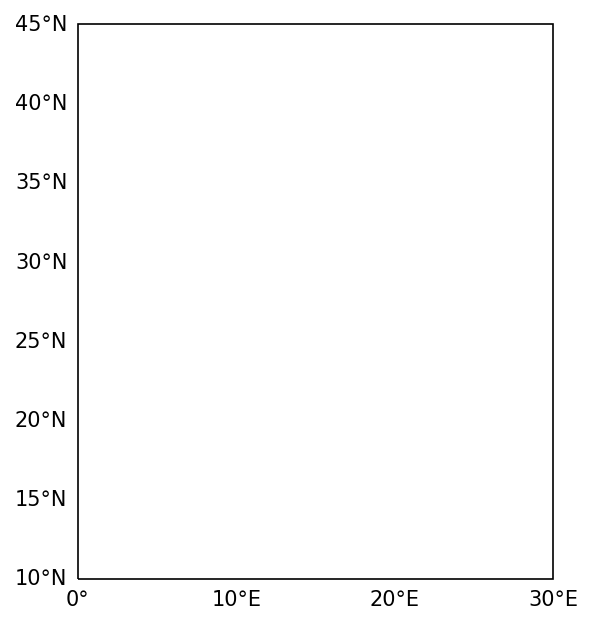

In [9]:
def setup_cartopy_plot(ax=None, bottom_labels=True, left_labels=True):
    data_projection = ccrs.PlateCarree()
    map_projection = ccrs.PlateCarree()
#     map_projection = ccrs.AlbersEqualArea(central_longitude=15, 
#                                           central_latitude=25,
#                                           standard_parallels=(20.0, 50.0))

    if ax is None:
        ax = plt.axes(projection=map_projection)

    ax.set_extent([-0.001, 30.001, 9.999, 45.0001], crs=ccrs.PlateCarree())
    gl = ax.gridlines(xlocs=np.arange(0, 31, 10), draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = bottom_labels
    gl.left_labels = left_labels
    gl.xlines = False
    gl.ylines = False

    vertices = [
        [ 0, 10],
        [30, 10],
        [30, 45],
        [ 0, 45],
        [ 0, 10]
    ]

    path = mpath.Path(vertices).interpolated(20)

#     ax.background_patch.set_facecolor('.5')
#     xlocs = np.arange(-90, 240, 30)
#     ylocs = np.arange(-75, 90, 15)
#     ax.gridlines(xlocs=xlocs, ylocs=ylocs, linewidth=.5)
#     ax.set_boundary(path, transform=data_projection)
    
    return ax

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
setup_cartopy_plot(ax)

<Axes: >

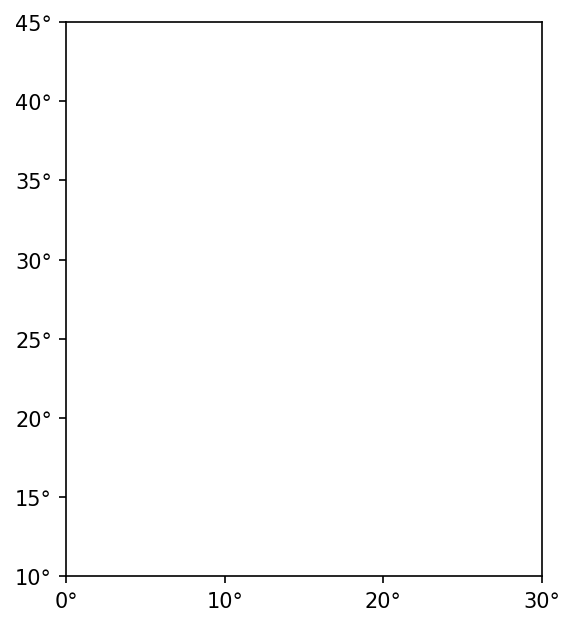

In [10]:
def setup_plan_plot(ax=None):
    if ax is None:
        ax = plt.axes()

    ax.set_xlim(0, 30)
    ax.set_ylim(10, 45)
    
    yticks = np.arange(10, 46, 5)
    latFormatter = pw.plt.LatitudeFormatter(direction_labels=False)
    ax.set_yticks(yticks)
    ax.set_yticklabels(latFormatter.format(yticks))
    
    xticks = np.arange(0, 31, 10)
    lonFormatter = pw.plt.LongitudeFormatter(direction_labels=False)
    ax.set_xticks(xticks)
    ax.set_xticklabels(lonFormatter.format(xticks))
    
    ax.set_aspect(1)
    
    return ax

fig, ax = plt.subplots()
setup_plan_plot(ax)

In [11]:
def integer_ticks(vmax, symmetric=True, spacing=None, nticks=None):
    '''
    Returns an array with ticks spaced by an integer and centered around zero.
    
    nticks is the number of non-negative ticks
    '''
    
    if spacing is not None and nticks is not None:
        raise RuntimeError("Can't specify both spacing and nticks")
        
    if spacing is not None:
        if symmetric:
            vmin = -np.floor(vmax/spacing)*spacing
        else:
            vmin = 0
            
        return np.arange(vmin, vmax*(1 + .01), spacing)
    
    if nticks is None:
        nticks = 4
        
    spacing = np.ceil(vmax/nticks)
    if symmetric:
        vmin = -np.floor(vmax/spacing)*spacing
    else:
        vmin = 0
    return np.arange(vmin, vmax*(1 + .01), spacing)
    

In [12]:
def round_up(x, multiple=1):
    '''
    Round up to the next multiple of 'multiple'
    '''
    x = float(x)
    
    if x > 0:
        return np.ceil(x/multiple)*multiple
    elif x < 0:
        return np.floor(x/multiple)*multiple
    else:
        return 0.0
    
def round_down(x, multiple=1):
    '''
    Round down to the next multiple of 'multiple'
    '''
    x = float(x)
    
    if x > 0:
        return np.floor(x/multiple)*multiple
    elif x < 0:
        return np.ceil(x/multiple)*multiple
    else:
        return 0.0

# Load datasets

## Constants

In [92]:
ρ0 = 1035 # Boussinesq reference density
g = 9.8
Ω = 7.29e-5
a = 6370e3
Δλ = 0.5 # zonal grid spacing
dpy = 360 # days per year

tavg = 50*dpy # number of days to average
tanim = 50*dpy # number of days to animate

## Grid

MOM calls coordinates different things in different outputs. This enforces as uniform standard.

In [93]:
coord_map_h = {'lath': 'yh', 'latq': 'yq', 'lonh': 'xh', 'lonq': 'xq'}
coord_map_v = {'Interface': 'zi', 'Layer': 'zl'}

Vertical coordinates are annoyingly not in `ocean_geometry.nc`. We load them from the initial conditions and add them to the grid.

In [96]:
grid = xr.open_dataset(os.path.join(expdir, 'OUTPUT/ocean_geometry.nc')).rename(coord_map_h)
ic = xr.open_dataset(os.path.join(expdir, 'OUTPUT/MOM_IC.nc')).squeeze().rename({**coord_map_h, **coord_map_v})

max_depth = float(grid.D.max())

grid['zi'] = ic.zi
grid['zl'] = ic.zl

Nx = len(grid.xh)
Ny = len(grid.yh)
Nl = len(grid.zl)

grid['gprime'] = (('zl',), g*np.hstack(([1], (grid.zl.diff(dim='zl')/ρ0).values)))

grid['fh'] = 2*Ω*sind(grid.yh)
grid['fq'] = 2*Ω*sind(grid.yq)

grid['βh'] = 2*Ω*cosd(grid.yh)/a
grid['βq'] = 2*Ω*cosd(grid.yq)/a

grid['maskH'] = grid.wet
grid['maskU'] = (['yh', 'xq'], np.ones((Ny, Nx+1)))
grid['maskU'][:,[0, -1]] = 0
grid['maskV'] = (['yq', 'xh'], np.ones((Ny+1, Nx)))
grid['maskV'][[0, -1],:] = 0

grid['maskZ'] = (['yq', 'xq'], np.ones((Ny+1, Nx+1)))
grid['maskZ'][[0, -1],:] = 0
grid['maskZ'][:,[0, -1]] = 0

# width of the basin in meters
grid['Lx_q'] = a*np.deg2rad(grid.geolonb.isel(xq=-1,yq=0))*cosd(grid.yq)
grid['Lx_h'] = a*np.deg2rad(grid.geolonb.isel(xq=-1,yq=0))*cosd(grid.yh)

grid

<xarray.Dataset>
Dimensions:  (yh: 324, xh: 240, yq: 325, xq: 241, zi: 4, zl: 3)
Coordinates:
  * yh       (yh) float64 10.06 10.18 10.31 10.43 ... 44.73 44.82 44.9 44.99
  * xh       (xh) float64 0.0625 0.1875 0.3125 0.4375 ... 29.69 29.81 29.94
  * yq       (yq) float64 10.0 10.12 10.25 10.37 ... 44.77 44.86 44.95 45.04
  * xq       (xq) float64 0.0 0.125 0.25 0.375 0.5 ... 29.62 29.75 29.87 30.0
    Time     timedelta64[ns] 00:00:00
  * zi       (zi) float64 1.034e+03 1.036e+03 1.037e+03 1.037e+03
  * zl       (zl) float64 1.035e+03 1.037e+03 1.037e+03
Data variables: (12/30)
    geolatb  (yq, xq) float64 ...
    geolonb  (yq, xq) float64 ...
    geolat   (yh, xh) float64 ...
    geolon   (yh, xh) float64 ...
    D        (yh, xh) float64 100.8 102.5 107.1 119.0 ... 100.0 100.0 100.0
    f        (yq, xq) float64 ...
    ...       ...
    maskH    (yh, xh) float64 ...
    maskU    (yh, xq) float64 0.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 0.0
    maskV    (yq, xh) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    maskZ    (yq, xq) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Lx_q     (yq) float64 3.285e+06 3.283e+06 3.282e+06 ... 2.361e+06 2.357e+06
    Lx_h     (yh) float64 3.284e+06 3.283e+06 3.281e+06 ... 2.362e+06 2.359e+06
Attributes:
    filename:  OUTPUT/ocean_geometry.nc

In [97]:
grid_op = xgcm.Grid(grid, periodic=False, boundary='fill', fill_value=0, coords={
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'inner': 'zl', 'outer': 'zi'},

})
grid_op

<xgcm.Grid>
X Axis (not periodic, boundary='fill'):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (not periodic, boundary='fill'):
  * center   yh --> outer
  * outer    yq --> center
Z Axis (not periodic, boundary='fill'):
  * inner    zl
  * outer    zi

## Snapshot variables

In [98]:
ds = xr.open_mfdataset(os.path.join(expdir, 'DIAG/snapshot_*.nc'), decode_times=False)

# averaging time in the netcdf
nc_Tavg = float(ds.time.diff(dim='time').isel(time=-1))
Navg = int(np.ceil(tanim/nc_Tavg))

snap = ds.isel(time=slice(-Navg,None)).load()
ds.close()

snap

<xarray.Dataset>
Dimensions:  (xq: 241, yh: 324, zl: 3, time: 600, xh: 240, yq: 325, zi: 4)
Coordinates:
  * xq       (xq) float64 0.0 0.125 0.25 0.375 0.5 ... 29.62 29.75 29.87 30.0
  * yh       (yh) float64 10.06 10.18 10.31 10.43 ... 44.73 44.82 44.9 44.99
  * zl       (zl) float64 1.035e+03 1.037e+03 1.037e+03
  * time     (time) float64 30.0 60.0 90.0 120.0 ... 1.794e+04 1.797e+04 1.8e+04
  * xh       (xh) float64 0.0625 0.1875 0.3125 0.4375 ... 29.69 29.81 29.94
  * yq       (yq) float64 10.0 10.12 10.25 10.37 ... 44.77 44.86 44.95 45.04
  * zi       (zi) float64 1.034e+03 1.036e+03 1.037e+03 1.037e+03
Data variables:
    u        (time, zl, yh, xq) float32 nan -0.03368 -0.07082 ... -7.927e-15 nan
    v        (time, zl, yq, xh) float32 nan nan nan nan nan ... nan nan nan nan
    h        (time, zl, yh, xh) float32 100.8 102.5 107.1 ... 1e-10 1e-10 1e-10
    e        (time, zi, yh, xh) float32 -0.00292 -0.003659 ... -100.0 -100.0
Attributes:
    NumFilesInSet:     1
    title:             MOM Experiment
    associated_files:  area_t: DIAG/static.nc
    grid_type:         regular
    grid_tile:         N/A

In [99]:
zeta = grid_op.interp(
    grid_op.interp(
        ((grid_op.diff(snap.v.fillna(0)*grid.dyCv, 'X') - grid_op.diff(snap.u.fillna(0)*grid.dxCu, 'Y'))/grid.Aq), 
        'X'),
    'Y').load()

In [100]:
# snap['speed'] = np.sqrt(grid_op.interp(snap.u.fillna(0)**2, 'X') + grid_op.interp(snap.v.fillna(0)**2, 'Y')).load()

# Animate

## Surface height and vorticity

### Three layers

In [71]:
# framedir = tempfile.mkdtemp()
# print(framedir)



In [101]:
vms = 1e5*np.abs(zeta).max(dim=('time', 'yh', 'xh')).values
vms

array([11.13928834,  2.12045355,  2.19321035])

In [102]:
ves = [20, - .05, 0.05]
cmap = mpl.cm.RdBu_r
xlim = (0, 30)
ylim = (10, 45)
t0 = snap.time[0]

for time in range(len(snap.time)):
    fld = 1e5*zeta.isel(time=time)
    with mpl.style.context({'font.size': 14}):
        fig, axs = plt.subplots(ncols=Nl, sharex=True, sharey=True, figsize=(13, 7))
        fig.set_facecolor('w')
    
        for zl, ax in enumerate(axs):
            setup_plan_plot(ax)
            ax.set_facecolor('0.7')
            vmin = -vms[zl]/4
            vmax =  vms[zl]/4
            norm = mpl.colors.Normalize(vmin, vmax)
    
            pc = ax.pcolormesh(fld.xh, fld.yh, fld.isel(zl=zl), vmin=vmin, vmax=vmax, cmap=cmap)
            # ax.set_title('$\eta_' + str(n) + '$')
    
            e = snap.e.isel(time=time, zi=zl).where(snap.e.isel(zi=zl, time=time) > -grid.D + .1)
            intensity = pw.plt.hillshade(135, 45, e, vertical_exageration=ves[zl])
            rgb = pw.plt.blend_shade(cmap(norm(fld.isel(zl=zl))), intensity, mid_intensity=.75, min_brightness=.3, max_brightness=.9)
            im = ax.imshow(np.nan_to_num(rgb, nan=.7), origin='lower', extent=xlim + ylim, zorder=3)
            cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', pad=.1, extend='both', label='$10^{-5}$ s$^{-1}$')
            ax.set_title('$\zeta_' + str(zl+1) + '$')
    
        fig.suptitle('$t = {:3.0f}$ years'.format((snap.time.isel(time=time) - t0)/360))
        fig.tight_layout()
        fig.savefig(os.path.join(snapdir, 'frame_{:04d}.png'.format(time)), bbox_inches='tight', dpi=150)
    
        plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [103]:
name = os.path.join(snapdir, 'zeta_eta')

cmd = 'ffmpeg -y -pattern_type glob -i "{:s}/*.png" -plays 0 -f apng {:s}.png'.format(snapdir, name)
print(cmd)
os.system(cmd)

ffmpeg -y -pattern_type glob -i "../slope/3layer/08/002/snapshot/zeta/*.png" -plays 0 -f apng ../slope/3layer/08/002/snapshot/zeta/zeta_eta.png


ffmpeg version 4.4.4 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/local --enable-swscale --enable-avfilter --enable-avresample --enable-libmp3lame --enable-libvorbis --enable-libopus --enable-librsvg --enable-libtheora --enable-libopenjpeg --enable-libmodplug --enable-libvpx --enable-libsoxr --enable-libspeex --enable-libass --enable-libbluray --enable-libzimg --enable-libzvbi --enable-lzma --enable-gnutls --enable-fontconfig --enable-libfreetype --enable-libfribidi --enable-libdav1d --enable-zlib --disable-libjack --disable-libopencore-amrnb --disable-libopencore-amrwb --disable-libxcb --disable-libxcb-shm --disable-libxcb-xfixes --disable-indev=jack --enable-opencl --disable-outdev=xv --enable-audiotoolbox --enable-videotoolbox --enable-sdl2 --disable-securetransport --mandir=/opt/local/share/man --enable-shared --enable-pthreads --cc=/usr/bin/clang --enable-libaom --enable-libsvtav1 --enabl

0

In [132]:
ffmpeg = 'ffmpeg'
name = os.path.join(expdir, 'zeta_eta')
cmd = '{:s} -y -pattern_type glob -i "{:s}/*.png" -codec:v libx264  -pix_fmt yuv420p -profile:v high -preset slow -vf scale="trunc(oh*a/2)*2:960, setpts=1.0*PTS" -threads 0 -framerate 10 -vb 20M {:s}.mp4'.format(
    ffmpeg, framedir, name);
print(cmd)
os.system(cmd)

ffmpeg -y -pattern_type glob -i "/var/folders/mw/nq2xq7qd08s09mh886d_91rh0000gn/T/tmpferik7ou/*.png" -codec:v libx264  -pix_fmt yuv420p -profile:v high -preset slow -vf scale="trunc(oh*a/2)*2:960, setpts=1.0*PTS" -threads 0 -framerate 10 -vb 20M ../../slope/3layer/0.125/zeta_eta.mp4


ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 13.0.0 (clang-1300.0.29.30)
  configuration: --prefix=/opt/local --enable-swscale --enable-avfilter --enable-avresample --enable-libmp3lame --enable-libvorbis --enable-libopus --enable-librsvg --enable-libtheora --enable-libopenjpeg --enable-libmodplug --enable-libvpx --enable-libsoxr --enable-libspeex --enable-libass --enable-libbluray --enable-libzvbi --enable-lzma --enable-gnutls --enable-fontconfig --enable-libfreetype --enable-libfribidi --enable-zlib --disable-libjack --disable-libopencore-amrnb --disable-libopencore-amrwb --disable-libxcb --disable-libxcb-shm --disable-libxcb-xfixes --disable-indev=jack --enable-opencl --disable-outdev=xv --enable-audiotoolbox --enable-videotoolbox --enable-sdl2 --disable-securetransport --mandir=/opt/local/share/man --enable-shared --enable-pthreads --cc=/usr/bin/clang --enable-libzimg --enable-libdav1d --arch=x86_64 --enable-x86asm --enable-libx

0

In [87]:
shutil.rmtree(framedir)

### Top layers

In [16]:
framedir = tempfile.mkdtemp()
print(framedir)

/var/folders/mw/nq2xq7qd08s09mh886d_91rh0000gn/T/tmp9_8yulal


In [17]:
vms = 1e5*np.abs(snap.zeta).max(dim=('time', 'yh', 'xh')).values
vms

array([10.36835453,  2.7726569 ,  1.22573514])

In [18]:
t0 = float(snap.time[0])

In [28]:
snap.time[]

<xarray.DataArray 'time' (time: 1800)>
array([180001., 180002., 180003., ..., 181798., 181799., 181800.])
Coordinates:
  * time     (time) float64 1.8e+05 1.8e+05 1.8e+05 ... 1.818e+05 1.818e+05
Attributes:
    units:          days since 0001-01-01 00:00:00
    long_name:      time
    axis:           T
    calendar_type:  360_DAY
    calendar:       360_day

In [29]:
zl = 1

ves = [20,- .05, 0.05]
cmap = mpl.cm.RdBu_r
xlim = (0, 30)
ylim = (10, 45)

for time in range(360):
    fld = 1e5*snap.zeta.isel(time=time, zl=zl)
    with mpl.style.context({'font.size': 14}):
        fig, ax = plt.subplots(ncols=1, figsize=(5, 7))
        fig.set_facecolor('w')

        setup_plan_plot(ax)
        ax.set_facecolor('0.7')
        vmin = -vms[zl]/4
        vmax =  vms[zl]/4
        norm = mpl.colors.Normalize(vmin, vmax)

        pc = ax.pcolormesh(fld.xh, fld.yh, fld, vmin=vmin, vmax=vmax, cmap=cmap)
        # ax.set_title('$\eta_' + str(n) + '$')

        e = snap.e.isel(time=time, zi=zl).where(snap.e.isel(zi=zl, time=time) > -grid.D + .1)
        intensity = pw.plt.hillshade(135, 45, e, vertical_exageration=ves[zl])
        rgb = pw.plt.blend_shade(cmap(norm(fld)), intensity, mid_intensity=.75, min_brightness=.3, max_brightness=.9)
        im = ax.imshow(np.nan_to_num(rgb, nan=.7), origin='lower', extent=xlim + ylim, zorder=3)
        cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', pad=.1, extend='both', label='$10^{-5}$ s$^{-1}$')
        ax.set_title('$\zeta_' + str(zl+1) + '$')

        # fig.suptitle('$t = {:3.0f}$ days'.format(float(fld.time - t0)))
        fig.tight_layout()
        fig.savefig(os.path.join(framedir, 'frame_{:04d}.png'.format(time)), bbox_inches='tight', dpi=150)

        plt.close()

In [30]:
ffmpeg = 'ffmpeg'
name = os.path.join(expdir, 'zeta_eta_zl2')
cmd = '{:s} -y -pattern_type glob -i "{:s}/*.png" -codec:v libx264  -pix_fmt yuv420p -profile:v high -preset slow -vf scale="trunc(oh*a/2)*2:960, setpts=1.0*PTS" -threads 0 -framerate 10 -vb 20M {:s}.mp4'.format(
    ffmpeg, framedir, name);
print(cmd)
os.system(cmd)

ffmpeg -y -pattern_type glob -i "/var/folders/mw/nq2xq7qd08s09mh886d_91rh0000gn/T/tmp9_8yulal/*.png" -codec:v libx264  -pix_fmt yuv420p -profile:v high -preset slow -vf scale="trunc(oh*a/2)*2:960, setpts=1.0*PTS" -threads 0 -framerate 10 -vb 20M ../../slope/3layer/0.125/zeta_eta_zl2.mp4


ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 13.0.0 (clang-1300.0.29.30)
  configuration: --prefix=/opt/local --enable-swscale --enable-avfilter --enable-avresample --enable-libmp3lame --enable-libvorbis --enable-libopus --enable-librsvg --enable-libtheora --enable-libopenjpeg --enable-libmodplug --enable-libvpx --enable-libsoxr --enable-libspeex --enable-libass --enable-libbluray --enable-libzvbi --enable-lzma --enable-gnutls --enable-fontconfig --enable-libfreetype --enable-libfribidi --enable-zlib --disable-libjack --disable-libopencore-amrnb --disable-libopencore-amrwb --disable-libxcb --disable-libxcb-shm --disable-libxcb-xfixes --disable-indev=jack --enable-opencl --disable-outdev=xv --enable-audiotoolbox --enable-videotoolbox --enable-sdl2 --disable-securetransport --mandir=/opt/local/share/man --enable-shared --enable-pthreads --cc=/usr/bin/clang --enable-libzimg --enable-libdav1d --arch=x86_64 --enable-x86asm --enable-libx

0

In [87]:
shutil.rmtree(framedir)

## Surface height and speed

In [89]:
framedir = tempfile.mkdtemp()
print(framedir)

/var/folders/mw/nq2xq7qd08s09mh886d_91rh0000gn/T/tmp4kpukdnz


In [90]:
vms = 100*np.abs(snap.speed).max(dim=('time', 'yh', 'xh')).values
vms

array([195.94273 ,  63.427902,  22.27568 ], dtype=float32)

In [91]:
t0 = float(snap.time[0])

In [102]:
ves = [20,- .05, 0.05]
cmap = cmocean.cm.tempo
xlim = (0, 30)
ylim = (10, 45)

for time in range(len(snap.time)):
    fld = 100*snap.speed.isel(time=time)
    with mpl.style.context({'font.size': 14}):
        fig, axs = plt.subplots(ncols=Nl, sharex=True, sharey=True, figsize=(13, 7))
        fig.set_facecolor('w')

        for zl, ax in enumerate(axs):
            setup_plan_plot(ax)
            ax.set_facecolor('0.7')
            vmin = 0
            vmax = 0.75*vms[zl]
            norm = mpl.colors.Normalize(vmin, vmax)

            pc = ax.pcolormesh(fld.xh, fld.yh, fld.isel(zl=zl), vmin=vmin, vmax=vmax, cmap=cmap)
            # ax.set_title('$\eta_' + str(n) + '$')

            e = snap.e.isel(time=time, zi=zl).where(snap.e.isel(zi=zl, time=time) > -grid.D + .1)
            intensity = pw.plt.hillshade(135, 45, e, vertical_exageration=ves[zl])
            rgb = pw.plt.blend_shade(cmap(norm(fld.isel(zl=zl))), intensity, mid_intensity=.75, min_brightness=.3, max_brightness=.9)
            im = ax.imshow(np.nan_to_num(rgb, nan=.7), origin='lower', extent=xlim + ylim, zorder=3)
            cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', pad=.1, extend='max', label='cm s$^{-1}$')
            ax.set_title('layer ' + str(zl+1))

        fig.suptitle('$t = {:3.0f}$ days'.format(float(fld.time - t0)))
        fig.tight_layout()
        fig.savefig(os.path.join(framedir, 'frame_{:04d}.png'.format(time)), bbox_inches='tight', dpi=150)

        plt.close()

In [103]:
ffmpeg = 'ffmpeg'
name = os.path.join(expdir, 'speed_eta')
cmd = '{:s} -y -pattern_type glob -i "{:s}/*.png" -codec:v libx264  -pix_fmt yuv420p -profile:v high -preset slow -vf scale="trunc(oh*a/2)*2:960, setpts=1.0*PTS" -threads 0 -framerate 10 -vb 20M {:s}.mp4'.format(
    ffmpeg, framedir, name);
print(cmd)
os.system(cmd)

ffmpeg -y -pattern_type glob -i "/var/folders/mw/nq2xq7qd08s09mh886d_91rh0000gn/T/tmp4kpukdnz/*.png" -codec:v libx264  -pix_fmt yuv420p -profile:v high -preset slow -vf scale="trunc(oh*a/2)*2:960, setpts=1.0*PTS" -threads 0 -framerate 10 -vb 20M ../../slope/3layer/0.125/speed_eta.mp4


ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 13.0.0 (clang-1300.0.29.30)
  configuration: --prefix=/opt/local --enable-swscale --enable-avfilter --enable-avresample --enable-libmp3lame --enable-libvorbis --enable-libopus --enable-librsvg --enable-libtheora --enable-libopenjpeg --enable-libmodplug --enable-libvpx --enable-libsoxr --enable-libspeex --enable-libass --enable-libbluray --enable-libzvbi --enable-lzma --enable-gnutls --enable-fontconfig --enable-libfreetype --enable-libfribidi --enable-zlib --disable-libjack --disable-libopencore-amrnb --disable-libopencore-amrwb --disable-libxcb --disable-libxcb-shm --disable-libxcb-xfixes --disable-indev=jack --enable-opencl --disable-outdev=xv --enable-audiotoolbox --enable-videotoolbox --enable-sdl2 --disable-securetransport --mandir=/opt/local/share/man --enable-shared --enable-pthreads --cc=/usr/bin/clang --enable-libzimg --enable-libdav1d --arch=x86_64 --enable-x86asm --enable-libx

0

In [87]:
shutil.rmtree(framedir)

# Close everything

In [104]:
grid.close()
ic.close()
snap.close()

In [134]:
del snap